In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.statespace import sarimax
from sklearn.ensemble import RandomForestClassifier

In [3]:
df=pd.read_excel('sales.xlsx')
df.head()

,SalesID,CustomerID,SalesRepID,ProductID,Sales Quantity (in tons),Sales Amount (in US$),Year,Month,Day
0,210001,R012,BB1988,S2022,16,16000.0,2021,Jan,3
1,210002,R012,AA1986,S2022,18,18000.0,2021,Jan,3
2,210003,R078,CG1990,F3031,4,4000.0,2021,Jan,4
3,210004,R056,BF1988,F3030,1,1300.0,2021,Jan,6
4,210005,R078,CG1990,F3032,8,5600.0,2021,Jan,6


In [4]:
df['Sales Quantity (in tons)'].isnull().sum()
print(df['Sales Amount (in US$)'].isnull().sum())


0


In [5]:
df.dtypes

SalesID                       int64
CustomerID                   object
SalesRepID                   object
ProductID                    object
Sales Quantity (in tons)      int64
Sales Amount (in US$)       float64
Year                          int64
Month                        object
Day                           int64
dtype: object

In [6]:
def preprocessing_cancel(data):
    data['price']=data['Sales Amount (in US$)']/data['Sales Quantity (in tons)']
    return data
aks=preprocessing_cancel(df)
aks1=aks.iloc[:, 6:] 
grouping=aks1.groupby(['Day','Month','Year']).agg({'price':'sum'}).reset_index()
listing=grouping['price']
print(listing)
#i want sum the dataset and make it into new list with the month is january and grouping by sum the sales by date

0      4700.0
1      7700.0
2      3400.0
3      1000.0
4       700.0
        ...  
546    3000.0
547    3000.0
548    1300.0
549    3000.0
550    1000.0
Name: price, Length: 551, dtype: float64


In [7]:
def outliers_basic(data):
    dataset=[]
    Q1=np.percentile(data,25)
    Q3=np.percentile(data,75)
    IQR=Q3-Q1
    outlier_step=1.5*IQR
    outlier=data[(data<Q1-outlier_step) | (data>Q3+outlier_step)]
    return outlier
eks=outliers_basic(listing)
listing_baru=listing[~listing.isin(eks)]

0      4700.0
2      3400.0
3      1000.0
4       700.0
5      3000.0
        ...  
546    3000.0
547    3000.0
548    1300.0
549    3000.0
550    1000.0
Name: price, Length: 513, dtype: float64


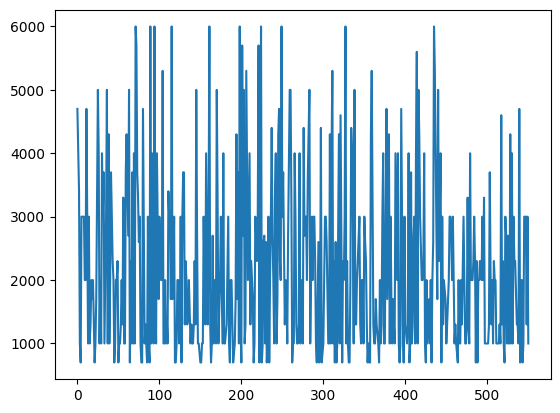

In [9]:
#we can conclude that the data is stationary with this descibe for all the time 
plt.plot(listing_baru)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6384518.5000 - learning_rate: 0.0010
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6077013.5000 - learning_rate: 0.0010
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6469557.5000 - learning_rate: 0.0010
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6228222.0000 - learning_rate: 0.0010
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6445292.5000 - learning_rate: 0.0010
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6517217.0000 - learning_rate: 0.0010
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6608979.0000 - learning_rate: 0.0010
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6498766.0000 - learning_rate: 0.0010
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7000321.0000 - learning_rate: 0.0010
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6358708.5000 - learning_rate: 0.0010
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

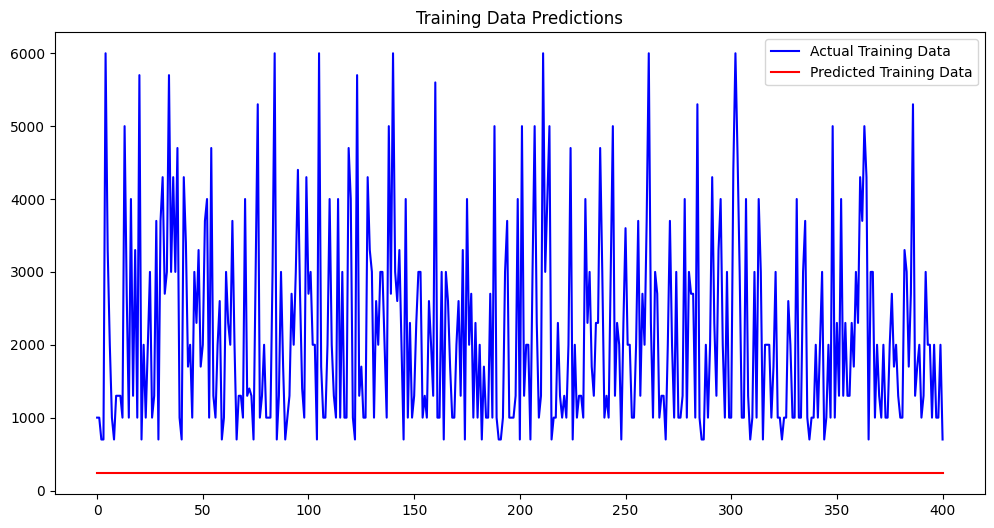

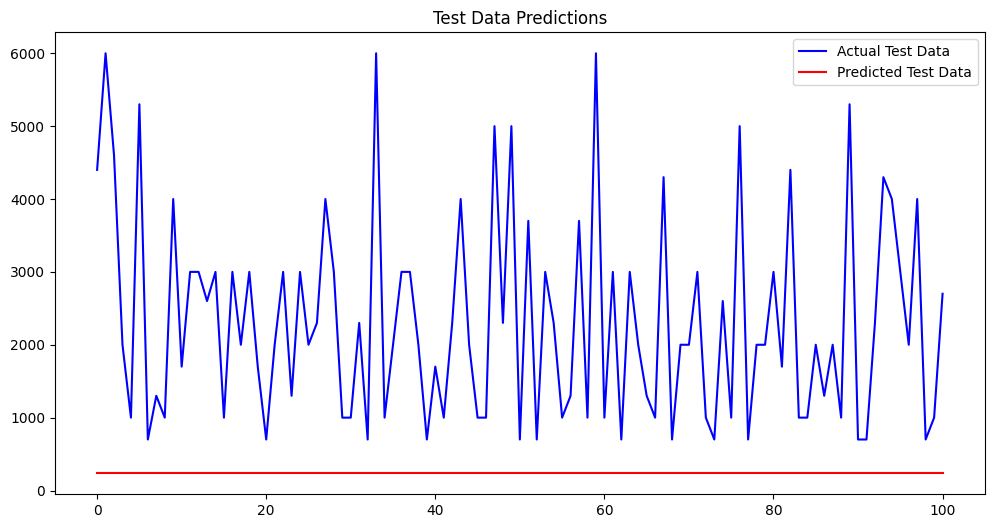

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Flatten,Dense
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

# Define the time step (sequence length)
time_step = 10  # Adjust based on your data

# Create training and test datasets
X, y = create_dataset(np.array(listing_baru), time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(32),  # Additional LSTM layer for more complexity
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define callbacks
rlronp = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, verbose=1)
estop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=30, verbose=1, restore_best_weights=True)

# Fit the model
historyLstm = model.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[rlronp, estop], verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plotting predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Training Data', color='blue')
plt.plot(train_predictions, label='Predicted Training Data', color='red')
plt.title('Training Data Predictions')
plt.legend()
plt.show()

# Plotting test predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Test Data', color='blue')
plt.plot(test_predictions, label='Predicted Test Data', color='red')
plt.title('Test Data Predictions')
plt.legend()
plt.show()